# Neural Style Transfer


In [105]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import imshow
import scipy.misc
from PIL import Image

Using vgg-19 as base CNN for our NST (vgg19 is been trained on large data set)

In [106]:
# tf.random.set_seed(272) #for constant value for each run
img_size=400
vgg=tf.keras.applications.VGG19(include_top=False,input_shape=(img_size,img_size,3),weights='imagenet')

vgg.trainable=False

In [107]:
for layer in vgg.layers:
  print(layer.name)

input_7
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


Content Cost Function

In [108]:
def content_cost(content_output,generated_output):
  a_C=content_output[-1]
  a_G=content_output[-1]
  _, n_H, n_W, n_C = a_G.get_shape().as_list()
  #reshaping a_C and a_G
  a_C_reshape=tf.transpose(tf.reshape(a_C,shape=[1,n_H*n_W,n_C]))
  a_G_reshape=tf.transpose(tf.reshape(a_G,shape=[1,n_H*n_W,n_C]))
  #Loss function for content
  J_content=(1/(4*n_H*n_W*n_C))*tf.reduce_sum(tf.square(tf.subtract(a_C_reshape,a_G_reshape)))

  return J_content

Style Cost Function

In [109]:
# Gram matrix
def gram_matrix(A):
  GA=tf.linalg.matmul(A,A,transpose_b=True)
  return GA

In [110]:
#style Cost

def style(a_S,a_G):
  _,n_H,n_W,n_C=a_G.get_shape().as_list()
  #reshaping a_S and a_G
  a_S=tf.transpose(tf.reshape(a_S,shape=[n_H*n_W,n_C]))
  a_G=tf.transpose(tf.reshape(a_G,shape=[n_H*n_W,n_C]))
  #gram matrix of style and generated respectively
  GS=gram_matrix(a_S)
  GG=gram_matrix(a_G)
  #Loss function for style
  J_style=(1/(4*n_C**2*(n_H*n_W)**2))*tf.reduce_sum(tf.square(tf.subtract(GS,GG)))
  return J_style

In [111]:
Style_Layers=[
    ('block1_conv1',.2),
    ('block2_conv1',.2),
    ('block3_conv1',.25),
    ('block4_conv1',.2),
    ('block5_conv1',.35)
]

In [112]:
def style_cost(style_image_output,generated_image_output,Style_Layers=Style_Layers):
  J_style=0
  a_S=style_image_output[:-1]
  a_G=generated_image_output[:-1]
  for i,weight in zip(range(len(a_S)),Style_Layers):
    J_style_layer=style(a_S[i],a_G[i])
    J_style+=weight[1]*J_style_layer

  return J_style

Total Cost

In [113]:
def total_cost(J_content,J_style,alpha=10,beta=40):
  J = alpha*J_content+beta*J_style
  return J

# Content image ***please paste the file name here***

(1, 400, 400, 3)


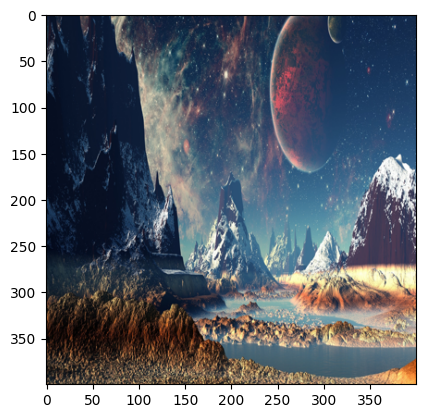

In [114]:
content_image = np.array(Image.open('planetsnight.jpg').resize((img_size, img_size)))
content_image=tf.constant(np.reshape(content_image,((1,)+content_image.shape)))


print(content_image.shape)
imshow(content_image[0])
plt.show()

# Style Image ***please paste the file name here***

(1, 400, 400, 3)


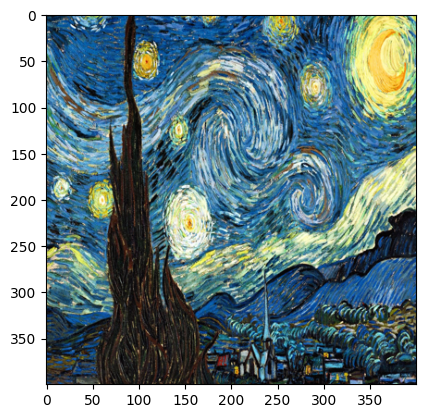

In [115]:
style_image=np.array(Image.open('starrynight.jpg').resize((img_size,img_size)))
style_image=tf.constant(np.reshape(style_image,((1,)+style_image.shape)))

print(style_image.shape)
imshow(style_image[0])
plt.show()

Generated Image

(1, 400, 400, 3)


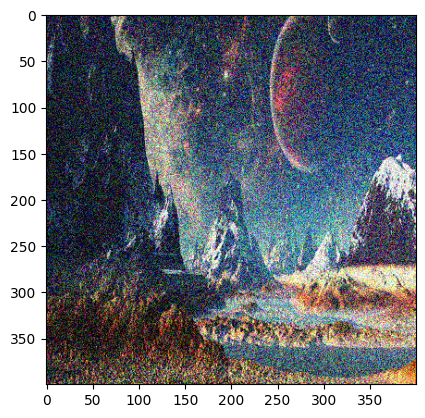

In [116]:
#slightly same as content image for faster calculation
generated_image=tf.Variable(tf.image.convert_image_dtype(content_image,tf.float32))
noise= tf.random.uniform(tf.shape(generated_image),-.35,.35);
generated_image=tf.add(generated_image,noise)
generated_image=tf.clip_by_value(generated_image,clip_value_min=0.0,clip_value_max=1.0)

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()

Loading the pre-trained vgg-19 model

In [117]:
def get_layer_output(vgg,layer_names):
  outputs=[vgg.get_layer(layer[0]).output for layer in layer_names]
  model=tf.keras.Model([vgg.input],outputs)
  return model

In [118]:
content_layer=[('block5_conv4',1)]
vgg_model_outputs=get_layer_output(vgg,Style_Layers+content_layer)

In [119]:
content_target=vgg_model_outputs(content_image)
style_targets=vgg_model_outputs(style_image)

Compute a_C and a_G

In [120]:
#content encoding
processed_content=tf.Variable(tf.image.convert_image_dtype(content_image,tf.float32))
a_C=vgg_model_outputs(processed_content)
#style ecoding
processed_style=tf.Variable(tf.image.convert_image_dtype(style_image,tf.float32))
a_S=vgg_model_outputs(processed_style)


In [121]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

Training step

In [122]:
optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)

@tf.function()
def train_step(generated_image):
  with tf.GradientTape() as tape:

    a_G=vgg_model_outputs(generated_image)


    J_style=style_cost(a_S,a_G)
    J_content=content_cost(a_C,a_G)

    J=total_cost(J_content,J_style)

  grad=tape.gradient(J,generated_image)
  optimizer.apply_gradients([(grad,generated_image)])
  generated_image.assign(clip_0_1(generated_image))
  return J

In [123]:
generated_image=tf.Variable(generated_image)


train the model

Epoch 0 
Epoch 250 
Epoch 500 
Epoch 750 
Epoch 1000 
Epoch 1250 
Epoch 1500 
Epoch 1750 
Epoch 2000 
Epoch 2250 
Epoch 2500 
Epoch 2750 
Epoch 3000 
Epoch 3250 
Epoch 3500 
Epoch 3750 
Epoch 4000 
Epoch 4250 
Epoch 4500 
Epoch 4750 
Epoch 5000 
Epoch 5250 
Epoch 5500 
Epoch 5750 
Epoch 6000 
Epoch 6250 
Epoch 6500 
Epoch 6750 
Epoch 7000 
Epoch 7250 
Epoch 7500 
Epoch 7750 
Epoch 8000 
Epoch 8250 
Epoch 8500 
Epoch 8750 
Epoch 9000 
Epoch 9250 
Epoch 9500 
Epoch 9750 
Epoch 10000 
Epoch 10250 
Epoch 10500 
Epoch 10750 
Epoch 11000 
Epoch 11250 
Epoch 11500 
Epoch 11750 
Epoch 12000 
Epoch 12250 
Epoch 12500 
Epoch 12750 
Epoch 13000 
Epoch 13250 
Epoch 13500 
Epoch 13750 
Epoch 14000 
Epoch 14250 
Epoch 14500 
Epoch 14750 
Epoch 15000 
Epoch 15250 
Epoch 15500 
Epoch 15750 
Epoch 16000 
Epoch 16250 
Epoch 16500 
Epoch 16750 
Epoch 17000 
Epoch 17250 
Epoch 17500 
Epoch 17750 
Epoch 18000 
Epoch 18250 
Epoch 18500 
Epoch 18750 
Epoch 19000 
Epoch 19250 
Epoch 19500 
Epoch 19750 
Epoch 

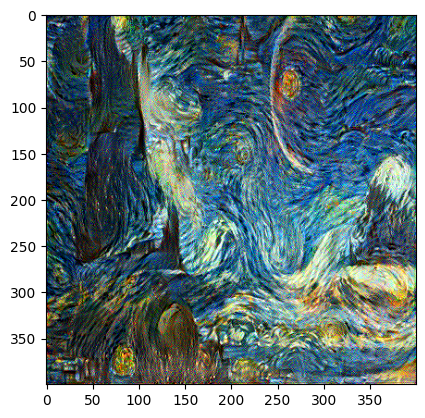

In [124]:
epochs=20001
for i in range(epochs):
  train_step(generated_image)
  if i % 250 == 0:
    print(f"Epoch {i} ")

image=tensor_to_image(generated_image)
imshow(image)
image.save(f"Output_image_{i}.jpg")
plt.show()

In [1]:
# Show the 3 images in a row
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
imshow(content_image[0])
ax.title.set_text('Content image')
ax = fig.add_subplot(1, 3, 2)
imshow(style_image[0])
ax.title.set_text('Style image')
ax = fig.add_subplot(1, 3, 3)
imshow(generated_image[0])
ax.title.set_text('Generated image')
plt.show()

NameError: ignored